In [ ]:
pip install prophet nbformat

  Obtaining dependency information for nbformat from https://files.pythonhosted.org/packages/a9/82/0340caa499416c78e5d8f5f05947ae4bc3cba53c9f038ab6e9ed964e22f1/nbformat-5.10.4-py3-none-any.whl.metadata
  Using cached nbformat-5.10.4-py3-none-any.whl.metadata (3.6 kB)
  Obtaining dependency information for fastjsonschema>=2.15 from https://files.pythonhosted.org/packages/90/2b/0817a2b257fe88725c25589d89aec060581aabf668707a8d03b2e9e0cb2a/fastjsonschema-2.21.1-py3-none-any.whl.metadata
  Obtaining dependency information for jsonschema>=2.6 from https://files.pythonhosted.org/packages/69/4a/4f9dbeb84e8850557c02365a0eee0649abe5eb1d84af92a25731c6c0f922/jsonschema-4.23.0-py3-none-any.whl.metadata
  Using cached jsonschema-4.23.0-py3-none-any.whl.metadata (7.9 kB)
  Obtaining dependency information for attrs>=22.2.0 from https://files.pythonhosted.org/packages/77/06/bb80f5f86020c4551da315d78b3ab75e8228f89f0162f2c3a819e407941a/attrs-25.3.0-py3-none-any.whl.metadata
  Obtaining dependency inform

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

## Data Wrangling

In [2]:
df = pd.read_csv("../data/Metro_zhvi_uc_sfrcondo_tier_0.33_0.67_sm_sa_month.csv")

In [3]:
print(df.shape)
df.head()

(895, 307)


,RegionID,SizeRank,RegionName,RegionType,StateName,2000-01-31,2000-02-29,2000-03-31,2000-04-30,2000-05-31,...,2024-05-31,2024-06-30,2024-07-31,2024-08-31,2024-09-30,2024-10-31,2024-11-30,2024-12-31,2025-01-31,2025-02-28
0,102001,0,United States,country,NaN,120187.291338,120398.739312,120660.965935,121223.390567,121870.673889,...,352914.638679,353466.996967,353612.598368,353851.962049,354295.143248,354873.991396,355358.916720,356067.058847,356686.351705,357138.132256
1,394913,1,"New York, NY",msa,NY,215997.979545,216915.849088,217842.219756,219719.405192,221663.295718,...,655775.193541,658849.712644,661590.751300,665325.900420,669344.302493,672861.282874,675626.194374,677406.746915,678476.263587,679755.746376
2,753899,2,"Los Angeles, CA",msa,CA,223845.478204,224678.467396,225788.001055,227995.600317,230410.021823,...,939338.772106,943348.163884,947786.830884,953046.620772,959562.454127,964859.346450,969423.172391,973502.535403,974045.970345,971995.753941
3,394463,3,"Chicago, IL",msa,IL,150668.753070,150808.228444,151073.861750,151734.691403,152529.589990,...,314546.393299,315749.091850,316472.773117,317379.333016,318365.905134,319327.319692,320348.475962,321575.006711,322895.868446,324218.209834
4,394514,4,"Dallas, TX",msa,TX,126168.387128,126224.582968,126289.185839,126456.952710,126678.148736,...,375056.853849,374392.029934,373452.807103,372801.133481,372603.234747,372497.321500,372208.925541,371684.816971,371161.901269,370383.507210


In [4]:
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')

In [6]:
df_melted = df.melt(
    id_vars=['regionid', 'sizerank', 'regionname', 'regiontype', 'statename'],        # keep this column intact
    var_name='date',               # name of the new "column name" column
    value_name='zhvi_price'        # name of the new "value" column
)

In [7]:
df_melted['date'] = pd.to_datetime(df_melted['date'])

In [8]:
df_melted['zhvi_price'] = pd.to_numeric(df_melted['zhvi_price'], errors='coerce')

In [9]:
df_melted = df_melted.dropna(subset=['zhvi_price', 'regionid', 'sizerank', 'regionname', 'regiontype', 'statename'])

In [10]:
unique_cities = df_melted['regionname'].unique()
print(unique_cities)

['New York, NY' 'Los Angeles, CA' 'Chicago, IL' 'Dallas, TX' 'Houston, TX'
 'Washington, DC' 'Philadelphia, PA' 'Miami, FL' 'Atlanta, GA'
 'Boston, MA' 'Phoenix, AZ' 'San Francisco, CA' 'Riverside, CA'
 'Detroit, MI' 'Seattle, WA' 'Minneapolis, MN' 'San Diego, CA' 'Tampa, FL'
 'Denver, CO' 'Baltimore, MD' 'St. Louis, MO' 'Orlando, FL'
 'Charlotte, NC' 'San Antonio, TX' 'Portland, OR' 'Sacramento, CA'
 'Pittsburgh, PA' 'Cincinnati, OH' 'Austin, TX' 'Las Vegas, NV'
 'Kansas City, MO' 'Columbus, OH' 'Cleveland, OH' 'San Jose, CA'
 'Nashville, TN' 'Virginia Beach, VA' 'Providence, RI' 'Jacksonville, FL'
 'Milwaukee, WI' 'Oklahoma City, OK' 'Raleigh, NC' 'Memphis, TN'
 'Richmond, VA' 'Louisville, KY' 'New Orleans, LA' 'Salt Lake City, UT'
 'Hartford, CT' 'Buffalo, NY' 'Birmingham, AL' 'Rochester, NY'
 'Grand Rapids, MI' 'Tucson, AZ' 'Urban Honolulu, HI' 'Tulsa, OK'
 'Fresno, CA' 'Worcester, MA' 'Omaha, NE' 'Bridgeport, CT'
 'Greenville, SC' 'Bakersfield, CA' 'Albany, NY' 'Knoxville, TN'
 'N

## Visualization

In [11]:
cities_to_plot = ['Portland, OR' , 'Seattle, WA', 'Dallas, TX' ]

In [12]:
filtered = df_melted[df_melted['regionname'].isin(cities_to_plot)]
filtered

,regionid,sizerank,regionname,regiontype,statename,date,zhvi_price
4,394514,4,"Dallas, TX",msa,TX,2000-01-31,126168.387128
15,395078,15,"Seattle, WA",msa,WA,2000-01-31,219843.553594
25,394998,25,"Portland, OR",msa,OR,2000-01-31,172050.077644
899,394514,4,"Dallas, TX",msa,TX,2000-02-29,126224.582968
910,395078,15,"Seattle, WA",msa,WA,2000-02-29,220544.278351
...,...,...,...,...,...,...,...
268515,395078,15,"Seattle, WA",msa,WA,2025-01-31,750148.870682
268525,394998,25,"Portland, OR",msa,OR,2025-01-31,548618.062109
269399,394514,4,"Dallas, TX",msa,TX,2025-02-28,370383.507210
269410,395078,15,"Seattle, WA",msa,WA,2025-02-28,751241.204396


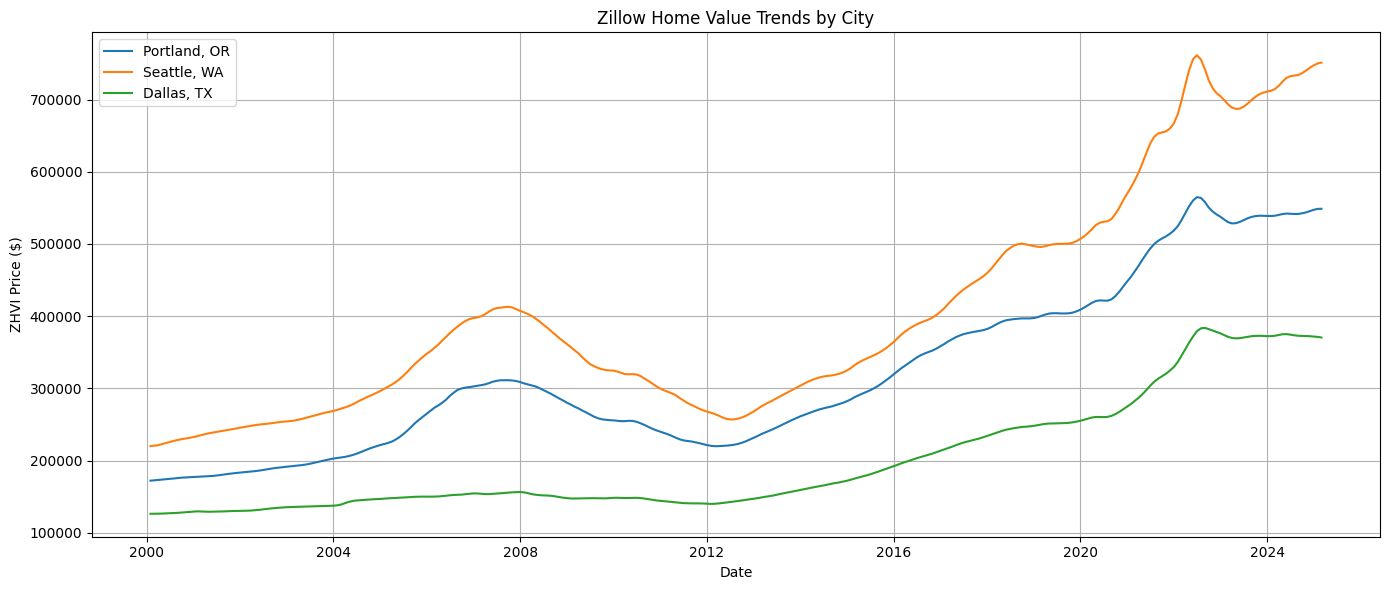

In [13]:
plt.figure(figsize=(14, 6))

for city in cities_to_plot:
    city_data = filtered[filtered['regionname'] == city]
    plt.plot(city_data['date'], city_data['zhvi_price'], label=city)

plt.title("Zillow Home Value Trends by City")
plt.xlabel("Date")
plt.ylabel("ZHVI Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Forecasting

In [14]:
city = 'Seattle, WA'
df_city = df_melted[df_melted['regionname'] == city][['date', 'zhvi_price']]
df_city = df_city.rename(columns={'date': 'ds', 'zhvi_price': 'y'})

In [15]:
from prophet import Prophet

model = Prophet()
model.fit(df_city)

/Users/adharshrajendran/projects/real-estate-forecaster/real-estate/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
12:22:26 - cmdstanpy - INFO - Chain [1] start processing
12:22:26 - cmdstanpy - INFO - Chain [1] done processing


In [16]:
future = model.make_future_dataframe(periods=12, freq='ME')  # Forecast next 12 months
forecast = model.predict(future)

In [17]:
from prophet.plot import plot_plotly
plot_plotly(model, forecast)